In [33]:
import matplotlib.pyplot as plt
import json
import torch
import pickle
from typing import Optional
from matplotlib.colors import Normalize
import numpy as np
import os

import experiments.utils as utils



dictionaries_path = "../dictionary_learning/dictionaries"

# Another way to generate graphs, where you manually populate sweep_name and submodule_trainers
sweep_name = "pythia70m_test_sae"
submodule_trainers = {"resid_post_layer_3": {"trainer_ids": [0]}}

# Current recommended way to generate graphs. You can copy paste ae_sweep_paths directly from bib_intervention.py
ae_sweep_paths = {
    "pythia70m_sweep_standard_ctx128_0712": {
        "resid_post_layer_3": {"trainer_ids": [1, 7, 11, 18]}
    }
}


ae_sweep_paths = {
    "pythia70m_sweep_standard_ctx128_0712": {
        # "resid_post_layer_0": {"trainer_ids": None},
        # "resid_post_layer_1": {"trainer_ids": None},
        # "resid_post_layer_2": {"trainer_ids": None},
        # "resid_post_layer_3": {"trainer_ids": None},
        # "resid_post_layer_4": {"trainer_ids": None},
    },
    "pythia70m_sweep_topk_ctx128_0730": {
        # "resid_post_layer_0": {"trainer_ids": None},
        # "resid_post_layer_1": {"trainer_ids": None},
        # "resid_post_layer_2": {"trainer_ids": None},
        "resid_post_layer_3": {"trainer_ids": None},
        # "resid_post_layer_4": {"trainer_ids": None},
    }
}

# ae_sweep_paths = {
#     "pythia70m_sweep_topk_ctx128_0730": {
#         # "resid_post_layer_0": {"trainer_ids": None},
#         # "resid_post_layer_1": {"trainer_ids": None},
#         # "resid_post_layer_2": {"trainer_ids": None},
#         "resid_post_layer_3": {"trainer_ids": None},
#         # "resid_post_layer_4": {"trainer_ids": None},
#     }
# }


sweep_name = list(ae_sweep_paths.keys())[0]
submodule_trainers = ae_sweep_paths[sweep_name]

# If not empty, this will filter to only include the specified class ids
# filter_class_ids = []
intended_filter_class_ids = [-2]
unintended_filter_class_ids = [-4]

ae_paths = []

for sweep_name, submodule_trainers in ae_sweep_paths.items():

    ae_group_paths = utils.get_ae_group_paths(
        dictionaries_path, sweep_name, submodule_trainers
    )
    ae_paths.extend(utils.get_ae_paths(ae_group_paths))


# If you haven't ran bib_intervenion.py before and there's no class accuracies file
# Set include_diff to False. You can still view the L0 / Loss recovered curve
# And you can view various SAE hyperparameters like sparsity penalty in the 3 variable plot
include_diff = True

print(ae_paths)

['../dictionary_learning/dictionaries/pythia70m_sweep_topk_ctx128_0730/resid_post_layer_3/trainer_0/', '../dictionary_learning/dictionaries/pythia70m_sweep_topk_ctx128_0730/resid_post_layer_3/trainer_1/', '../dictionary_learning/dictionaries/pythia70m_sweep_topk_ctx128_0730/resid_post_layer_3/trainer_2/', '../dictionary_learning/dictionaries/pythia70m_sweep_topk_ctx128_0730/resid_post_layer_3/trainer_3/', '../dictionary_learning/dictionaries/pythia70m_sweep_topk_ctx128_0730/resid_post_layer_3/trainer_4/', '../dictionary_learning/dictionaries/pythia70m_sweep_topk_ctx128_0730/resid_post_layer_3/trainer_5/', '../dictionary_learning/dictionaries/pythia70m_sweep_topk_ctx128_0730/resid_post_layer_3/trainer_6/', '../dictionary_learning/dictionaries/pythia70m_sweep_topk_ctx128_0730/resid_post_layer_3/trainer_7/', '../dictionary_learning/dictionaries/pythia70m_sweep_topk_ctx128_0730/resid_post_layer_3/trainer_8/', '../dictionary_learning/dictionaries/pythia70m_sweep_topk_ctx128_0730/resid_post_

In [34]:
results = {}
threshold = 0.1
threshold = 10

# There's a potential issue as we currently assume that all SAEs have the same classes.


def get_classes(first_path: str) -> list[int]:
    class_accuracies_file = f"{first_path}/class_accuracies.pkl"
    with open(class_accuracies_file, "rb") as f:
        class_accuracies = pickle.load(f)
    return list(class_accuracies[-1].keys())


for ae_path in ae_paths:

    eval_results_file = f"{ae_path}/eval_results.json"

    if not os.path.exists(eval_results_file):
        print(f"Warning: {eval_results_file} does not exist.")
        continue

    with open(eval_results_file, "r") as f:
        eval_results = json.load(f)

    l0 = eval_results["l0"]
    frac_recovered = eval_results["frac_recovered"]

    results[ae_path] = {
        "l0": l0,
        "frac_recovered": frac_recovered,
    }

    config_file = f"{ae_path}/config.json"

    with open(config_file, "r") as f:
        config = json.load(f)

    results[ae_path]["trainer_class"] = config["trainer"]["trainer_class"]

    # results[ae_path]["l1_penalty"] = config["trainer"]["l1_penalty"]
    # results[ae_path]["lr"] = config["trainer"]["lr"]
    # results[ae_path]["dict_size"] = config["trainer"]["dict_size"]

    # # Use these to analyze hyperparameters vs L0 / frac recovered
    # results[ae_path]["average_diff"] = results[ae_path]["l1_penalty"]
    # results[ae_path]["average_diff"] = results[ae_path]["lr"]  
    # results[ae_path]["average_diff"] = results[ae_path]["dict_size"]

    if not include_diff:
        continue

    intended_diffs = []
    unintended_diffs = []

    class_accuracies_file = f"{ae_path}/class_accuracies.pkl"

    if not os.path.exists(class_accuracies_file):
        print(f"Warning: {class_accuracies_file} does not exist. Removing this path from results.")
        del results[ae_path]
        continue

    with open(class_accuracies_file, "rb") as f:
        class_accuracies = pickle.load(f)

    classes = list(class_accuracies[-1].keys())

    print(class_accuracies)
    # for class_id in classes:
    #     print(class_accuracies[-1][class_id])

    for class_id in classes:

        if intended_filter_class_ids and class_id not in intended_filter_class_ids:
            continue

        clean = class_accuracies[-1][class_id]
        patched = class_accuracies[class_id][threshold][class_id]

        diff = clean - patched
        intended_diffs.append(diff)

    for intended_class_id in classes:

        if intended_filter_class_ids and intended_class_id not in intended_filter_class_ids:
            continue

        for unintended_class_id in classes:
            if intended_class_id == unintended_class_id:
                continue

            if unintended_filter_class_ids and unintended_class_id not in unintended_filter_class_ids:
                continue

            clean = class_accuracies[-1][unintended_class_id]
            patched = class_accuracies[intended_class_id][threshold][unintended_class_id]
            diff = clean - patched
            unintended_diffs.append(diff)

    average_intended_diff = sum(intended_diffs) / len(intended_diffs)
    average_unintended_diff = sum(unintended_diffs) / len(unintended_diffs)
    average_diff = average_intended_diff - average_unintended_diff

    results[ae_path]["average_diff"] = average_diff
    results[ae_path]["average_intended_diff"] = average_intended_diff
    results[ae_path]["average_unintended_diff"] = average_unintended_diff


    # results[ae_path]["average_diff"] = average_intended_diff


{-1: {-4: 0.9020000696182251, -2: 0.9760000705718994}, -4: {10: {-4: 0.8330000638961792, -2: 0.968000054359436}, 50: {-4: 0.6160000562667847, -2: 0.971000075340271}, 500: {-4: 0.5040000081062317, -2: 0.9790000319480896}, 1000: {-4: 0.503000020980835, -2: 0.9760000705718994}}, -2: {10: {-4: 0.8880000710487366, -2: 0.8390000462532043}, 50: {-4: 0.8910000324249268, -2: 0.6760000586509705}, 500: {-4: 0.8830000162124634, -2: 0.5700000524520874}, 1000: {-4: 0.8800000548362732, -2: 0.5509999990463257}}}
{-1: {-4: 0.9020000696182251, -2: 0.9760000705718994}, -4: {10: {-4: 0.8330000638961792, -2: 0.9740000367164612}, 50: {-4: 0.6130000352859497, -2: 0.968000054359436}, 500: {-4: 0.5020000338554382, -2: 0.9740000367164612}, 1000: {-4: 0.5070000290870667, -2: 0.9740000367164612}}, -2: {10: {-4: 0.89000004529953, -2: 0.8380000591278076}, 50: {-4: 0.8850000500679016, -2: 0.6760000586509705}, 500: {-4: 0.8820000290870667, -2: 0.5670000314712524}, 1000: {-4: 0.8730000257492065, -2: 0.5470000505447388

In [35]:
l0_threshold = None
l0_threshold = 500

if l0_threshold is not None:
    filtered_results = {
        path: data for path, data in results.items() 
        if data['l0'] <= l0_threshold
    }
    
    # Optional: Print how many results were filtered out
    filtered_count = len(results) - len(filtered_results)
    print(f"Filtered out {filtered_count} results with L0 > {l0_threshold}")
    
    # Replace the original results with the filtered results
    results = filtered_results

Filtered out 4 results with L0 > 500


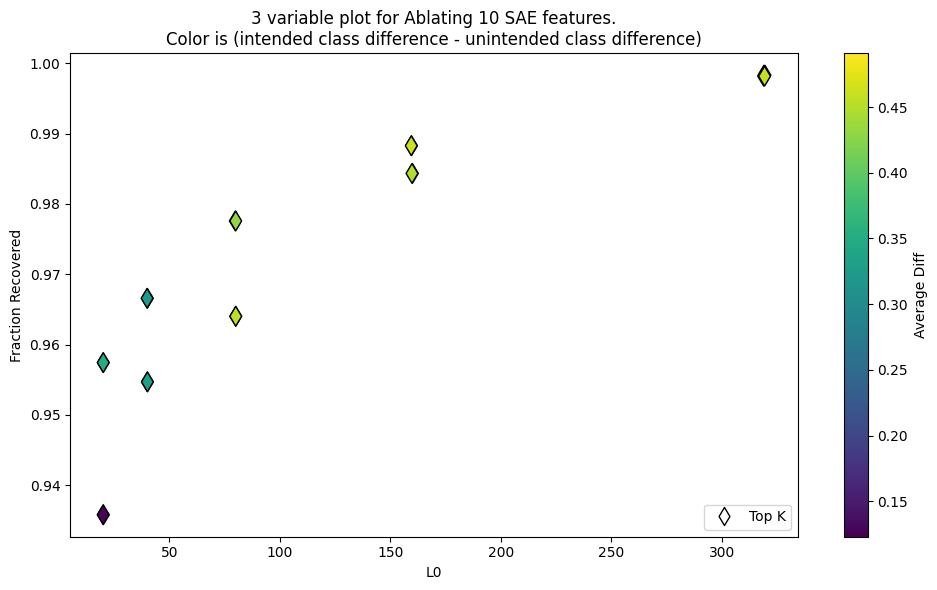

In [39]:
# “Gated SAE”, “Gated SAE w/ p-annealing”, “Standard”, “Standard w/ p-annealing”
label_lookup = {
    "StandardTrainer": "Standard",
    "PAnnealTrainer": "Standard w/ p-annealing",
    "GatedSAETrainer": "Gated SAE",
    # "GatedAnnealTrainer": "Gated SAE w/ p-annealing",
    "TrainerTopK": "Top K",
    # "Identity": "Identity",
}

unique_trainers = list(label_lookup.keys())

# create a dictionary mapping trainer types to marker shapes
trainer_markers = dict(zip(unique_trainers, ["o", "X", "^", "d"]))



def plot_3var_graph(
    results: dict,
    xlims: Optional[tuple[float, float]] = None,
    y_lims: Optional[tuple[float, float]] = None,
    colorbar_label: str = "Average Diff",
    output_filename: Optional[str] = None,
    legend_location: str = "lower right",
):
    # Extract data from results
    l0_values = [data['l0'] for data in results.values()]
    frac_recovered_values = [data['frac_recovered'] for data in results.values()]
    average_diff_values = [data['average_diff'] for data in results.values()]

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a normalize object for color scaling
    norm = Normalize(vmin=min(average_diff_values), vmax=max(average_diff_values))

    handles, labels = [], []

    for trainer, marker in trainer_markers.items():

        # Filter data for this trainer
        trainer_data = {k: v for k, v in results.items() if v['trainer_class'] == trainer}
        
        if not trainer_data:
            continue  # Skip this trainer if no data points

        l0_values = [data['l0'] for data in trainer_data.values()]
        frac_recovered_values = [data['frac_recovered'] for data in trainer_data.values()]
        average_diff_values = [data['average_diff'] for data in trainer_data.values()]

        # Plot data points
        scatter = ax.scatter(
            l0_values,
            frac_recovered_values,
            c=average_diff_values,
            cmap="viridis",
            marker=marker,
            s=100,
            label=label_lookup[trainer],
            norm=norm,
            edgecolor="black"
        )

        # custom legend stuff
        _handle, _ = scatter.legend_elements(prop="sizes")
        _handle[0].set_markeredgecolor("black")
        _handle[0].set_markerfacecolor("white")
        _handle[0].set_markersize(10)
        if marker == "d":
            _handle[0].set_markersize(13)
        handles += _handle
        labels.append(label_lookup[trainer])

    # Add colorbar
    cbar = fig.colorbar(scatter, ax=ax, label=colorbar_label)

    # Set labels and title
    ax.set_xlabel("L0")
    ax.set_ylabel("Fraction Recovered")
    ax.set_title(f"""Ablating Top {threshold} features from attribution patching.
                 Color is (intended class difference - unintended class difference).
                 intended class = gender probe, unintended class = profession probe""")

    ax.legend(handles, labels, loc=legend_location)

    # Set axis limits
    if xlims:
        ax.set_xlim(*xlims)
    if y_lims:
        ax.set_ylim(*y_lims)

    plt.tight_layout()

    # Save and show the plot
    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight")
    plt.show()

# print(results)
if include_diff:
    plot_3var_graph(results)


In [37]:
import plotly.graph_objects as go
from typing import Optional, Dict, Any

def plot_interactive_3var_graph(
    results: Dict[str, Dict[str, float]],
    xlims: Optional[tuple[float, float]] = None,
    y_lims: Optional[tuple[float, float]] = None,
    output_filename: Optional[str] = None,
):
    # Extract data from results
    ae_paths = list(results.keys())
    l0_values = [data['l0'] for data in results.values()]
    frac_recovered_values = [data['frac_recovered'] for data in results.values()]

    third_value = [data['average_diff'] for data in results.values()]
    
    # Create the scatter plot
    fig = go.Figure()

    # Add trace
    fig.add_trace(go.Scatter(
        x=l0_values,
        y=frac_recovered_values,
        mode='markers',
        marker=dict(
            size=10,
            color=third_value,  # Color points based on frac_recovered
            colorscale='Viridis',  # You can change this colorscale
            showscale=True
        ),
        text=[f'AE Path: {ae}<br>L0: {l0:.4f}<br>Frac Recovered: {fr:.4f}<br>Average Diff: {ad:.4f}' 
              for ae, l0, fr, ad in zip(ae_paths, l0_values, frac_recovered_values, third_value)],
        hoverinfo='text'
    ))

    # Update layout
    fig.update_layout(
        title='L0 vs Fraction Recovered',
        xaxis_title='L0',
        yaxis_title='Fraction Recovered',
        hovermode='closest'
    )

    # Set axis limits
    if xlims:
        fig.update_xaxes(range=xlims)
    if y_lims:
        fig.update_yaxes(range=y_lims)

    # Save and show the plot
    if output_filename:
        fig.write_html(output_filename)
    
    fig.show()

# Example usage:
plot_interactive_3var_graph(results)

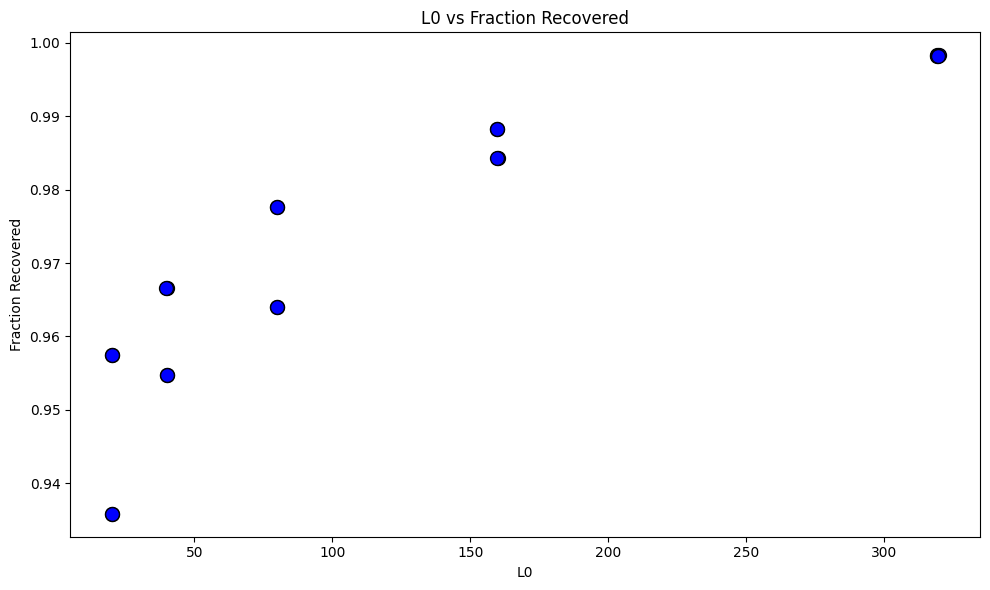

In [38]:
def plot_2var_graph(
    results: dict,
    xlims: Optional[tuple[float, float]] = None,
    y_lims: Optional[tuple[float, float]] = None,
    output_filename: Optional[str] = None,
):
    # Extract data from results
    l0_values = [data['l0'] for data in results.values()]
    frac_recovered_values = [data['frac_recovered'] for data in results.values()]

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot data points
    ax.scatter(
        l0_values,
        frac_recovered_values,
        s=100,
        edgecolor="black",
        c="blue"  # You can change this color as needed
    )

    # Set labels and title
    ax.set_xlabel("L0")
    ax.set_ylabel("Fraction Recovered")
    ax.set_title("L0 vs Fraction Recovered")

    # Set axis limits
    if xlims:
        ax.set_xlim(*xlims)
    if y_lims:
        ax.set_ylim(*y_lims)

    plt.tight_layout()

    # Save and show the plot
    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight")
    plt.show()

# Example usage:
plot_2var_graph(results)